#  EmissionSense: CO₂ Emissions Analysis & Prediction

This Python script is part of the *EmissionSense* project, focused on analyzing and forecasting vehicle CO₂ emissions using data-driven methodologies. The aim is to identify major emission contributors and provide insights that encourage cleaner and more sustainable technologies.

## 📌 Project Goals:
- Load and explore a dataset of vehicle specifications and fuel usage
- Apply data preprocessing techniques such as encoding, scaling, and outlier handling
- Conduct exploratory data analysis (EDA) to reveal patterns and relationships
- Build and evaluate regression models to predict CO₂ emissions effectively
- Use statistical testing and optimization techniques for advanced analysis

## 🔧 Technologies and Libraries Used:
This project is powered by Python’s data science ecosystem, specifically:
- **pandas** and **numpy** for efficient data handling  
- **matplotlib**, **seaborn**, and **plotly** for rich data visualizations  
- **scikit-learn** and **xgboost** for machine learning and evaluation  
- **scipy** for statistical analysis and optimization  
- **missingno** and **imbalanced-learn** for managing missing data and class imbalance

In [1]:
import pandas as pd
import numpy as np
from scipy.stats import zscore
from scipy.stats import skew
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
import missingno as msno
from pandas.plotting import scatter_matrix
from numpy import log1p
from sklearn.preprocessing import StandardScaler, MinMaxScaler, PolynomialFeatures, LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from xgboost import XGBRegressor
from scipy.stats import f_oneway, chi2_contingency
from scipy.special import boxcox1p
from scipy.stats import boxcox
from imblearn.over_sampling import SMOTE
from numpy import log1p

from scipy.optimize import minimize, linprog
from sklearn.decomposition import PCA

import os
from datetime import datetime
import warnings
warnings.filterwarnings("ignore")

plt.style.use("fivethirtyeight")
sns.set_theme(style="whitegrid", palette="muted")
px.defaults.template = "plotly_dark"
px.defaults.color_continuous_scale = "Viridis"

plt.rcParams['figure.figsize'] = [12, 6]
plt.rcParams['axes.labelsize'] = 12
plt.rcParams['axes.titlesize'] = 15
plt.rcParams['xtick.labelsize'] = 10
plt.rcParams['ytick.labelsize'] = 10

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
pd.options.display.precision = 2

### importing the dataset

In [2]:
sahil_df = pd.read_csv('co2.csv')

In [3]:
print(sahil_df.head())

    Make       Model Vehicle Class  Engine Size(L)  Cylinders Transmission  \
0  ACURA         ILX       COMPACT             2.0          4          AS5   
1  ACURA         ILX       COMPACT             2.4          4           M6   
2  ACURA  ILX HYBRID       COMPACT             1.5          4          AV7   
3  ACURA     MDX 4WD   SUV - SMALL             3.5          6          AS6   
4  ACURA     RDX AWD   SUV - SMALL             3.5          6          AS6   

  Fuel Type  Fuel Consumption City (L/100 km)  \
0         Z                               9.9   
1         Z                              11.2   
2         Z                               6.0   
3         Z                              12.7   
4         Z                              12.1   

   Fuel Consumption Hwy (L/100 km)  Fuel Consumption Comb (L/100 km)  \
0                              6.7                               8.5   
1                              7.7                               9.6   
2                   

## Data Preprocessing

Data preprocessing is a critical phase in any machine learning pipeline, as it directly impacts model accuracy and reliability. It involves transforming raw data into a clean, consistent format suitable for analysis and modeling. This includes identifying and resolving issues such as duplicates, inconsistent data types, missing values, and irrelevant features. 

By applying appropriate preprocessing techniques, the dataset becomes more structured, enabling efficient training of predictive models and reducing the risk of biased or inaccurate results.

### Handling missing value

In [4]:
# Function to identify and report missing data
def report_missing_values(df):
    print("\nMissing Data Check:")
    missing = df.isnull().sum()
    missing = missing[missing > 0]
    if not missing.empty:
        print(missing)
    else:
        print("No missing values detected.")

# Running the function on my dataset
report_missing_values(sahil_df)


Missing Data Check:
No missing values detected.


### Handling duplicate values

In [5]:
# Identify and report duplicate records in the dataset
dup_flags = sahil_df.duplicated()
duplicate_count = dup_flags.sum()

if duplicate_count:
    print(f"Duplicates detected: {duplicate_count} rows appear more than once.")
else:
    print("No duplicate entries found in the dataset.")

Duplicates detected: 1103 rows appear more than once.


In [6]:
# Remove duplicate records if any are found
if duplicate_count > 0:
    sahil_df = sahil_df.drop_duplicates().reset_index(drop=True)
    print(f"{duplicate_count} duplicate rows have been dropped.")
    print(f"Updated dataset dimensions: {sahil_df.shape}")
else:
    print("No duplicate data was found. No action needed.")

1103 duplicate rows have been dropped.
Updated dataset dimensions: (6282, 12)


### Encoding categrical features

In [7]:

print("\nEncoding categorical features...")

categorical_columns = ["Make", "Model", "Vehicle Class", "Transmission", "Fuel Type"]
encoders = {}

for col in categorical_columns:
    le = LabelEncoder()
    sahil_df[col] = sahil_df[col].astype(str)  # convert everything to string
    sahil_df[col] = le.fit_transform(sahil_df[col])
    encoders[col] = le

print("Encoding complete.")



Encoding categorical features...
Encoding complete.


In [9]:
numerical_features = [
    "Engine Size(L)",
    "Cylinders",
    "Fuel Consumption City (L/100 km)",
    "Fuel Consumption Hwy (L/100 km)",
    "Fuel Consumption Comb (L/100 km)",
    "CO2 Emissions(g/km)"
]

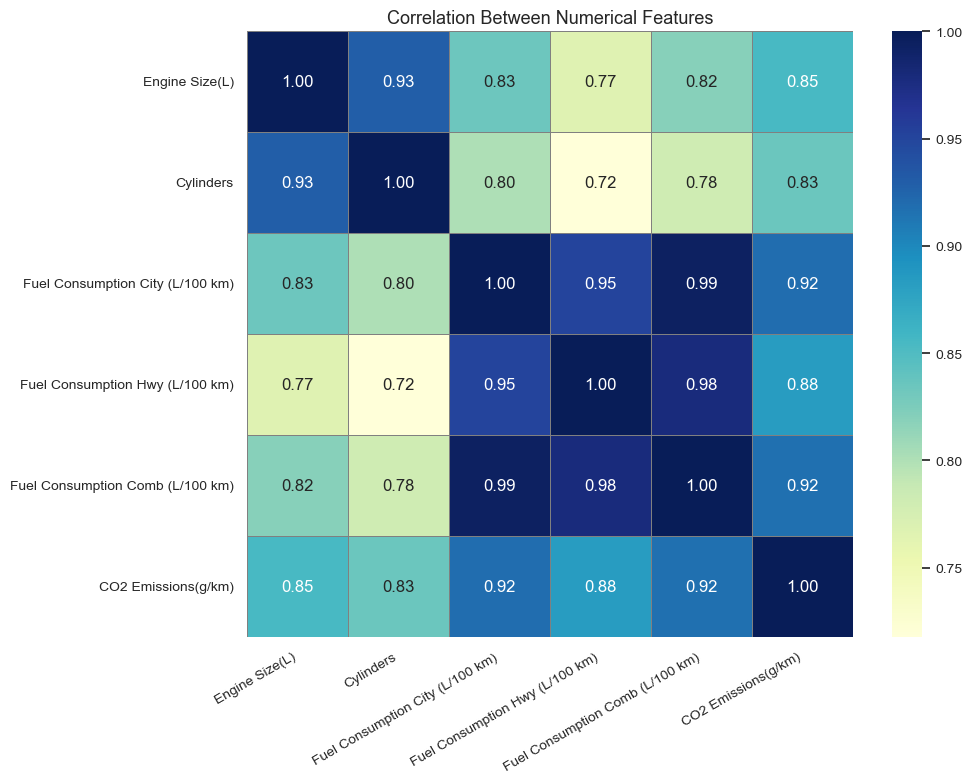

In [10]:
# Generate correlation matrix for numeric variables
corr_data = sahil_df[numerical_features].corr()

# Create the heatmap figure
fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(
    data=corr_data,
    annot=True,
    fmt=".2f",
    cmap="YlGnBu",
    linewidths=0.4,
    linecolor='gray',
    square=True,
    ax=ax
)

ax.set_title("Correlation Between Numerical Features", fontsize=13)
plt.xticks(rotation=30, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

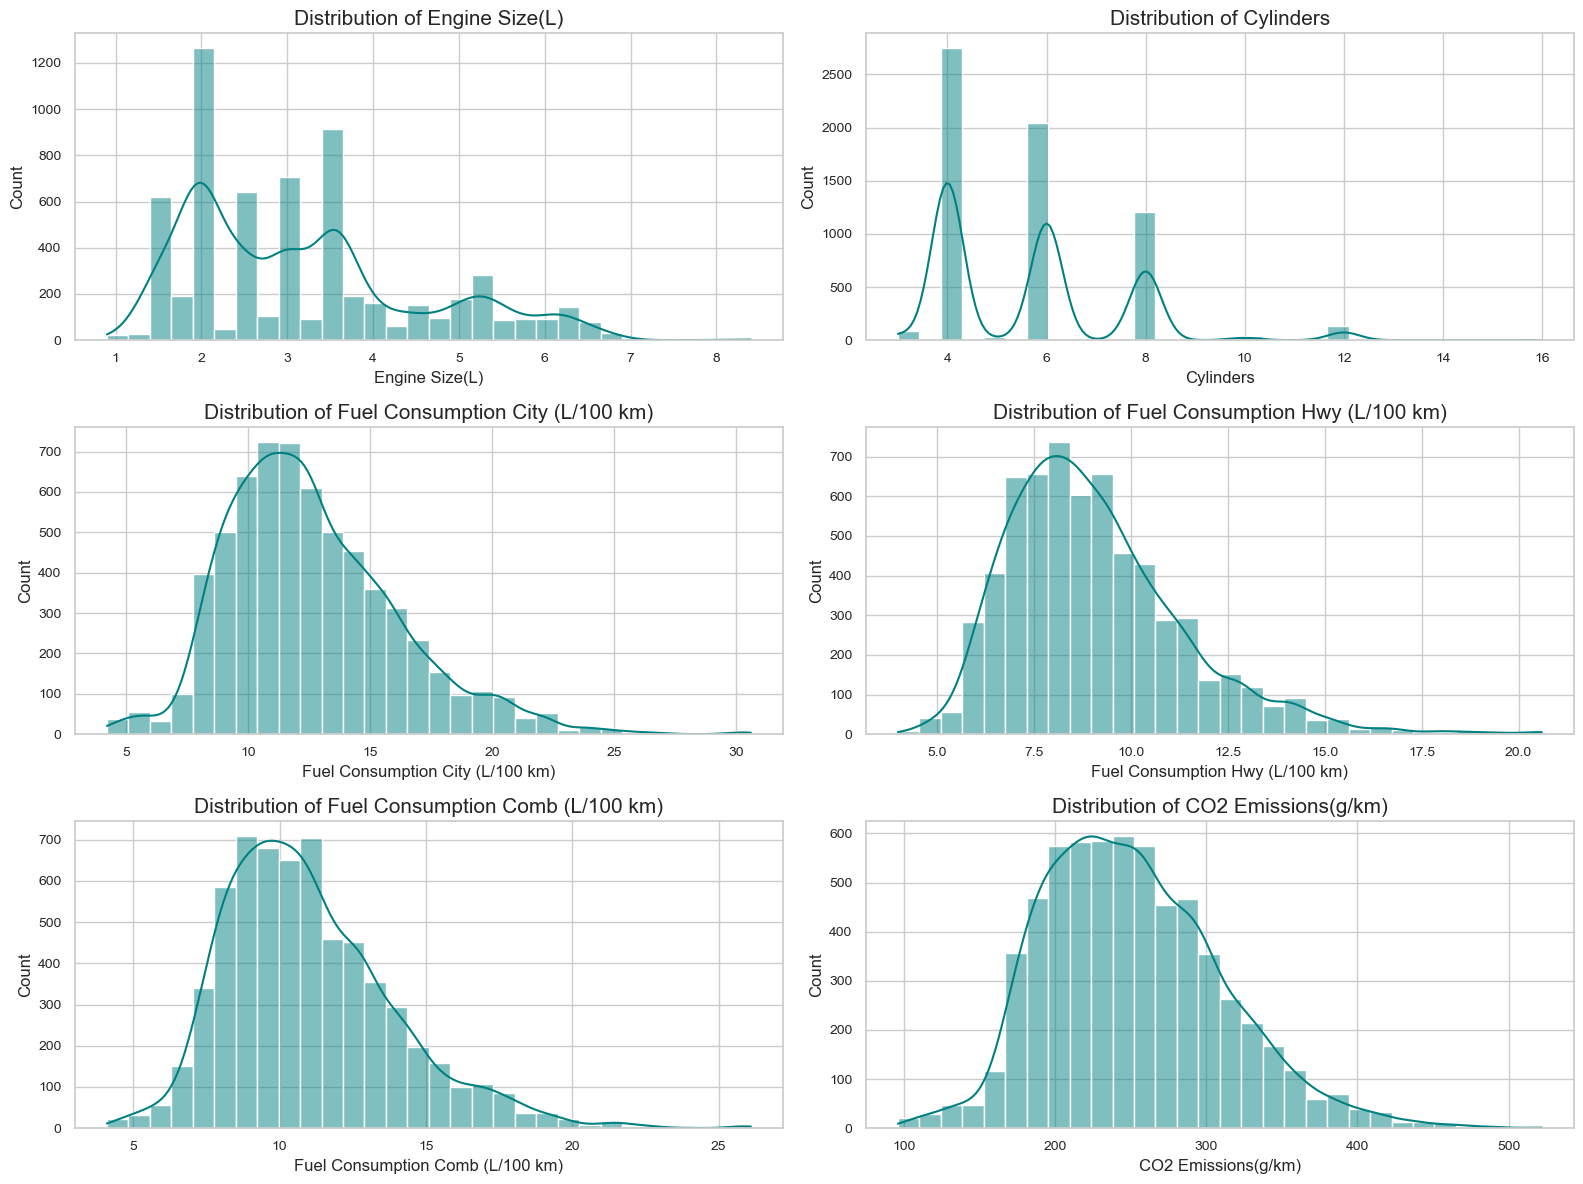

In [11]:
# Plot histograms with KDE overlays for selected numeric features
plt.figure(figsize=(16, 12))
for i, col in enumerate(numerical_features, 1):
    plt.subplot(3, 2, i)
    sns.histplot(sahil_df[col], kde=True, color="teal", bins=30)
    plt.title(f"Distribution of {col}")
plt.tight_layout()
plt.show()

### Review numerical columns for zero entries

In [12]:

numeric_columns = sahil_df.select_dtypes(include=["float64", "int64"]).columns

print("Zero-value counts for numeric features:")
for column in numeric_columns:
    zero_entries = (sahil_df[column] == 0).sum()
    print(f"  -> {column}: {zero_entries} zeros")

Zero-value counts for numeric features:
  -> Make: 51 zeros
  -> Model: 2 zeros
  -> Vehicle Class: 903 zeros
  -> Engine Size(L): 0 zeros
  -> Cylinders: 0 zeros
  -> Transmission: 28 zeros
  -> Fuel Type: 147 zeros
  -> Fuel Consumption City (L/100 km): 0 zeros
  -> Fuel Consumption Hwy (L/100 km): 0 zeros
  -> Fuel Consumption Comb (L/100 km): 0 zeros
  -> Fuel Consumption Comb (mpg): 0 zeros
  -> CO2 Emissions(g/km): 0 zeros


### Handling skewness of each numerical feature

In [13]:

skew_scores = {}
for feature in numeric_columns:
    skew_val = skew(sahil_df[feature])
    skew_scores[feature] = skew_val
    print(f"{feature} → Skewness: {skew_val:.2f}")

# Identify variables with significant skew
print("\nFeatures with substantial skewness (absolute skew > 1):")
strongly_skewed = {col: val for col, val in skew_scores.items() if abs(val) > 1}

if strongly_skewed:
    for col, skew_val in strongly_skewed.items():
        print(f"{col}: {skew_val:.2f}")
else:
    print("No numeric columns show strong skew.")

Make → Skewness: 0.28
Model → Skewness: 0.02
Vehicle Class → Skewness: 0.02
Engine Size(L) → Skewness: 0.81
Cylinders → Skewness: 1.11
Transmission → Skewness: -0.15
Fuel Type → Skewness: -1.79
Fuel Consumption City (L/100 km) → Skewness: 0.84
Fuel Consumption Hwy (L/100 km) → Skewness: 1.11
Fuel Consumption Comb (L/100 km) → Skewness: 0.92
Fuel Consumption Comb (mpg) → Skewness: 0.92
CO2 Emissions(g/km) → Skewness: 0.56

Features with substantial skewness (absolute skew > 1):
Cylinders: 1.11
Fuel Type: -1.79
Fuel Consumption Hwy (L/100 km): 1.11


In [14]:
# Identify positively skewed numeric columns
log_transform_candidates = [feature for feature, value in strongly_skewed.items() if value > 1]

print("Applying log transformation to positively skewed features:")

for feature in log_transform_candidates:
    sahil_df[feature] = log1p(sahil_df[feature])
    print(f"Log transformation applied to: {feature}")

Applying log transformation to positively skewed features:
Log transformation applied to: Cylinders
Log transformation applied to: Fuel Consumption Hwy (L/100 km)


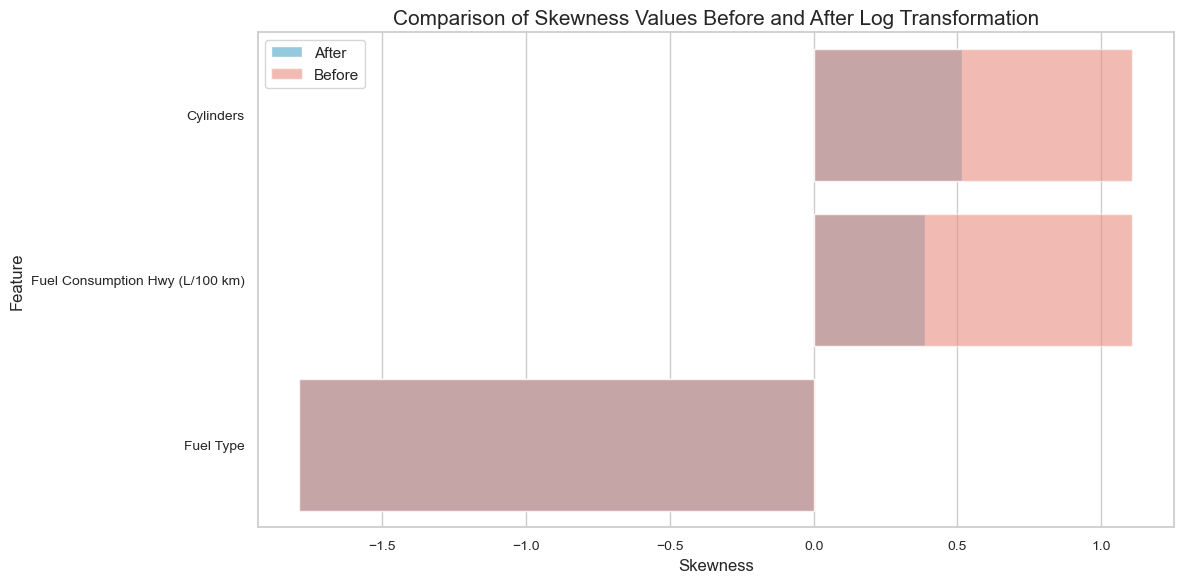

In [15]:
# Recalculate skewness after transformation
adjusted_skew_scores = {feature: skew(sahil_df[feature]) for feature in strongly_skewed.keys()}

# Prepare comparison DataFrame
skew_comparison = pd.DataFrame({
    "Feature": list(strongly_skewed.keys()),
    "Before Transformation": [strongly_skewed[feature] for feature in strongly_skewed],
    "After Transformation": [adjusted_skew_scores[feature] for feature in strongly_skewed]
}).sort_values(by="After Transformation", ascending=False)

# Plot skewness values before and after transformation
plt.figure(figsize=(12, 6))
sns.barplot(data=skew_comparison, x="After Transformation", y="Feature", color="skyblue", label="After")
sns.barplot(data=skew_comparison, x="Before Transformation", y="Feature", color="salmon", alpha=0.6, label="Before")

plt.title("Comparison of Skewness Values Before and After Log Transformation")
plt.xlabel("Skewness")
plt.ylabel("Feature")
plt.legend()
plt.tight_layout()
plt.show()



In [16]:
# 🔍 Step: Inspecting Zero Occurrences Across All Features

print("\n📊 Evaluating Zero-Value Distribution Across Dataset Columns:\n")

for column in sahil_df.columns:
    zero_total = (sahil_df[column] == 0).sum()
    zero_percent = (zero_total / len(sahil_df)) * 100

    print(f"🔎 {column}: {zero_total} zeros found ({zero_percent:.2f}%)")


📊 Evaluating Zero-Value Distribution Across Dataset Columns:

🔎 Make: 51 zeros found (0.81%)
🔎 Model: 2 zeros found (0.03%)
🔎 Vehicle Class: 903 zeros found (14.37%)
🔎 Engine Size(L): 0 zeros found (0.00%)
🔎 Cylinders: 0 zeros found (0.00%)
🔎 Transmission: 28 zeros found (0.45%)
🔎 Fuel Type: 147 zeros found (2.34%)
🔎 Fuel Consumption City (L/100 km): 0 zeros found (0.00%)
🔎 Fuel Consumption Hwy (L/100 km): 0 zeros found (0.00%)
🔎 Fuel Consumption Comb (L/100 km): 0 zeros found (0.00%)
🔎 Fuel Consumption Comb (mpg): 0 zeros found (0.00%)
🔎 CO2 Emissions(g/km): 0 zeros found (0.00%)



📦 Generating Boxplots to Detect Outliers in Numerical Features...


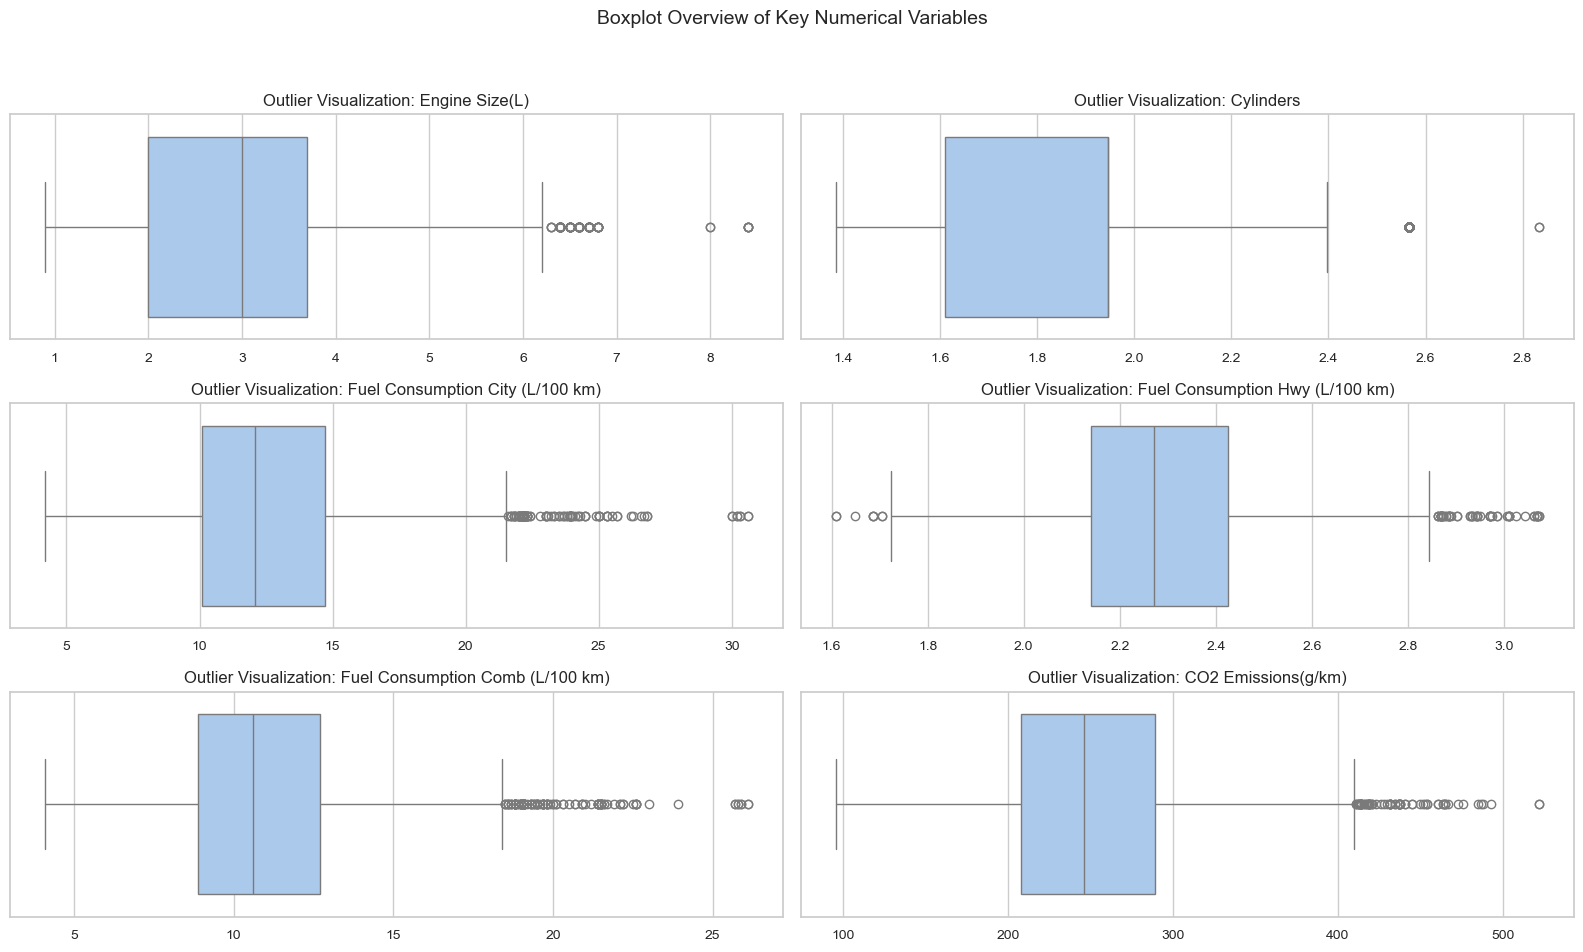

In [17]:
# Visual Exploration of Numerical Attributes Using Boxplots
print("\n📦 Generating Boxplots to Detect Outliers in Numerical Features...")

plt.figure(figsize=(16, 10))
# Define relevant numeric columns for summary
key_numeric_features = [
    "Engine Size(L)",
    "Cylinders",
    "Fuel Consumption City (L/100 km)",
    "Fuel Consumption Hwy (L/100 km)",
    "Fuel Consumption Comb (L/100 km)",
    "CO2 Emissions(g/km)",
]
# Loop through each numerical column and plot its boxplot
for idx, feature in enumerate(key_numeric_features, start=1):
    plt.subplot(3, 2, idx)  # Adjust grid if you have more/fewer features
    sns.boxplot(data=sahil_df, x=feature, palette="pastel")
    plt.title(f"Outlier Visualization: {feature}", fontsize=12)
    plt.xlabel("")  # Hide x-label for cleaner visuals

plt.suptitle("Boxplot Overview of Key Numerical Variables", fontsize=14)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


 Exploring the Frequency of Categories in 'Fuel Type'...



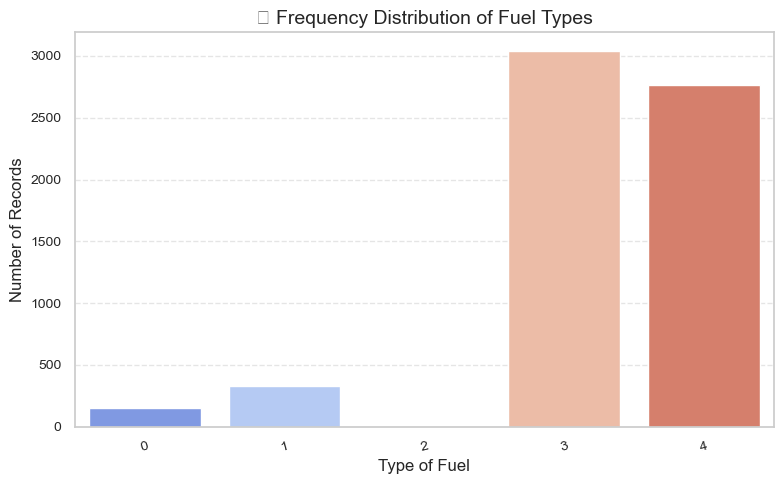

In [18]:
# Distribution Analysis of Categorical Variables

import matplotlib.pyplot as plt
import seaborn as sns

print("\n Exploring the Frequency of Categories in 'Fuel Type'...\n")

# Set up the canvas
plt.figure(figsize=(8, 5))
sns.countplot(data=sahil_df, x="Fuel Type", palette="coolwarm")

# Aesthetic enhancements
plt.title("🔍 Frequency Distribution of Fuel Types", fontsize=14)
plt.xlabel("Type of Fuel", fontsize=12)
plt.ylabel("Number of Records", fontsize=12)
plt.xticks(rotation=15)
plt.grid(axis="y", linestyle="--", alpha=0.5)
plt.tight_layout()

# Show the visual
plt.show()

In [19]:
def iqr_outlier_cleaner(frame, feature):
    """Applies IQR filtering to exclude extreme values from a numeric column."""
    q1 = frame[feature].quantile(0.25)
    q3 = frame[feature].quantile(0.75)
    iqr_gap = q3 - q1
    lower_edge = q1 - 1.5 * iqr_gap
    upper_edge = q3 + 1.5 * iqr_gap

    return frame[(frame[feature] >= lower_edge) & (frame[feature] <= upper_edge)]

print("\n Initiating Outlier Removal Procedure Using IQR...\n")

# Apply outlier filtering to each numeric variable
for metric in key_numeric_features:
    pre_count = sahil_df.shape[0]
    sahil_df = iqr_outlier_cleaner(sahil_df, metric)
    post_count = sahil_df.shape[0]
    removed = pre_count - post_count

    print(f" {metric}: Removed {removed} rows identified as outliers.")


 Initiating Outlier Removal Procedure Using IQR...

 Engine Size(L): Removed 121 rows identified as outliers.
 Cylinders: Removed 64 rows identified as outliers.
 Fuel Consumption City (L/100 km): Removed 128 rows identified as outliers.
 Fuel Consumption Hwy (L/100 km): Removed 29 rows identified as outliers.
 Fuel Consumption Comb (L/100 km): Removed 35 rows identified as outliers.
 CO2 Emissions(g/km): Removed 10 rows identified as outliers.


## 🧹 Data Preprocessing Pipeline

Preprocessing is a crucial stage to ensure the quality and reliability of the dataset before model training. The following steps were applied sequentially to prepare the data:

###  Steps Completed:

1. **Handling Missing Values**
   - Null or NaN entries were identified and appropriately filled or removed based on the context of each feature.

2. **Removing Duplicate Records**
   - Duplicate rows were dropped to avoid data redundancy and biased learning.

3. **Encoding Categorical Features**
   - Categorical columns (e.g., Make, Model, Fuel Type) were converted into numerical format using label encoding for model compatibility.

4. **Handling Skewness and Zero Proportions**
   - Skewed numerical columns were treated to normalize their distribution.
   - Features with a high percentage of zero values were identified and zeros were replaced with small constants where necessary.

5. **Outlier Removal**
   - Outliers in numerical columns were detected using the Interquartile Range (IQR) method and removed to improve model stability.

---

These steps ensure a cleaner, more consistent dataset — setting the stage for accurate and reliable model training.

## 🧠 Feature Transformation

Feature Transformation (also called Feature Engineering) is the process of modifying, creating, or selecting meaningful features to improve model performance.

### ✨ Key Actions:
- Encode categorical variables  
- Normalize or scale numerical features  
- Handle skewness  
- Create new features or combine existing ones  

Good features = Better models. 🔍

##  Section 4: Feature Transformation

Feature Transformation, also known as Feature Engineering, plays a vital role in improving model accuracy and interpretability by preparing the dataset with the most informative attributes.

###  **Planned Workflow**

1.  **Selecting Key Features**  
   Filter out the most influential features by analyzing correlations and applying statistical methods to remove redundancy.

2.  **Generating Additional Features**  
   Construct new variables from existing ones—like ratios, interactions, or efficiency indicators—to enrich the dataset.

3. **Scaling & Normalizing Data**  
   Standardize numerical columns to maintain consistency and improve model convergence during training.

4.  **Converting Categorical Data**  
   Translate categorical fields into a machine-readable format using encoding strategies such as one-hot or label encoding.

5.  **Improving Feature Quality**  
   Use mathematical transformations (e.g., logarithmic or polynomial adjustments) to enhance feature behavior and distribution.

These transformations ensure that all features are in a form that aligns well with the assumptions of linear models and improves their predictive power.

In [20]:
# Step 1: Generate Polynomial Features
from sklearn.preprocessing import PolynomialFeatures, StandardScaler

# Select numerical columns for polynomial expansion
numeric_cols = [
    'Engine Size(L)', 
    'Cylinders', 
    'Fuel Consumption City (L/100 km)',
    'Fuel Consumption Hwy (L/100 km)', 
    'Fuel Consumption Comb (L/100 km)'
]

# Initialize the polynomial transformer
poly_builder = PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)
poly_features = poly_builder.fit_transform(sahil_df[numeric_cols])

# Create a DataFrame for the polynomial features
poly_feature_df = pd.DataFrame(poly_features, columns=poly_builder.get_feature_names_out(numeric_cols))

In [21]:
# Step 2: Scale the Polynomial Features
print("Scaling numerical features...")

# Initialize standard scaler
scaler = StandardScaler()

# Scale the polynomial features
scaled_values = scaler.fit_transform(poly_feature_df)

# Create a new DataFrame with scaled feature names
scaled_features = pd.DataFrame(
    scaled_values, 
    columns=[f"{col}_scaled" for col in poly_feature_df.columns]
)

# Drop original numeric columns and add scaled features
sahil_df_scaled = sahil_df.drop(columns=numeric_cols).reset_index(drop=True)
sahil_df_scaled = pd.concat([sahil_df_scaled, scaled_features], axis=1)

print("Polynomial numerical features have been standardized.")

Scaling numerical features...
Polynomial numerical features have been standardized.


In [22]:
#  Categorical Variable Transformation

print("Encoding selected categorical columns into binary features...")

# List of columns to encode
categoricals = ['Make', 'Model', 'Vehicle Class', 'Transmission', 'Fuel Type']

# Separate out categorical columns and encode each
encoded_blocks = []
for cat in categoricals:
    dummy_block = pd.get_dummies(sahil_df_scaled[cat], prefix=cat)
    encoded_blocks.append(dummy_block.iloc[:, 1:])  # remove first column to avoid redundancy

# Remove original categorical features from dataset
base_data = sahil_df_scaled.drop(columns=categoricals)

# Merge numerical and newly encoded data
encoded_data = pd.concat([base_data] + encoded_blocks, axis=1)

print(f"{len(categoricals)} categorical columns successfully one-hot encoded.")

Encoding selected categorical columns into binary features...
5 categorical columns successfully one-hot encoded.


In [23]:
from sklearn.preprocessing import StandardScaler

# Step 1: Scale the dataset (excluding target column)
scaler = StandardScaler()
scaled_features = scaler.fit_transform(encoded_data.drop(columns=["CO2 Emissions(g/km)"]))

# Step 2: Apply PCA
pca = PCA(n_components=10)
principal_components = pca.fit_transform(scaled_features)

# Step 3: Create DataFrame
pca_columns = [f"PCA_Component_{i+1}" for i in range(10)]
pca_df = pd.DataFrame(principal_components, columns=pca_columns)

# Step 4: Merge target variable
final_data = pd.concat([pca_df, encoded_data["CO2 Emissions(g/km)"].reset_index(drop=True)], axis=1)

In [24]:
print(f"Final Dataset Shape: {final_data.shape}")
final_data.head()

Final Dataset Shape: (5895, 11)


,PCA_Component_1,PCA_Component_2,PCA_Component_3,PCA_Component_4,PCA_Component_5,PCA_Component_6,PCA_Component_7,PCA_Component_8,PCA_Component_9,PCA_Component_10,CO2 Emissions(g/km)
0,-3.27,0.98,0.04,0.18,-0.37,-0.48,-0.06,-5.58e-01,0.66,1.82,196
1,-2.17,1.41,0.10,-0.30,-0.14,0.10,0.10,5.11e-03,0.82,-0.15,221
2,-6.47,1.42,-0.16,1.99,-1.47,0.16,-0.36,-1.86e-01,0.52,-0.51,136
3,1.05,0.28,-0.34,-0.90,1.45,-0.10,-0.25,1.85e-01,-0.83,0.15,255
4,0.49,0.32,-0.33,-0.84,1.34,0.02,-0.32,1.38e-01,-0.62,0.27,244


🔍 Visualizing Correlations Among Polynomial Features...


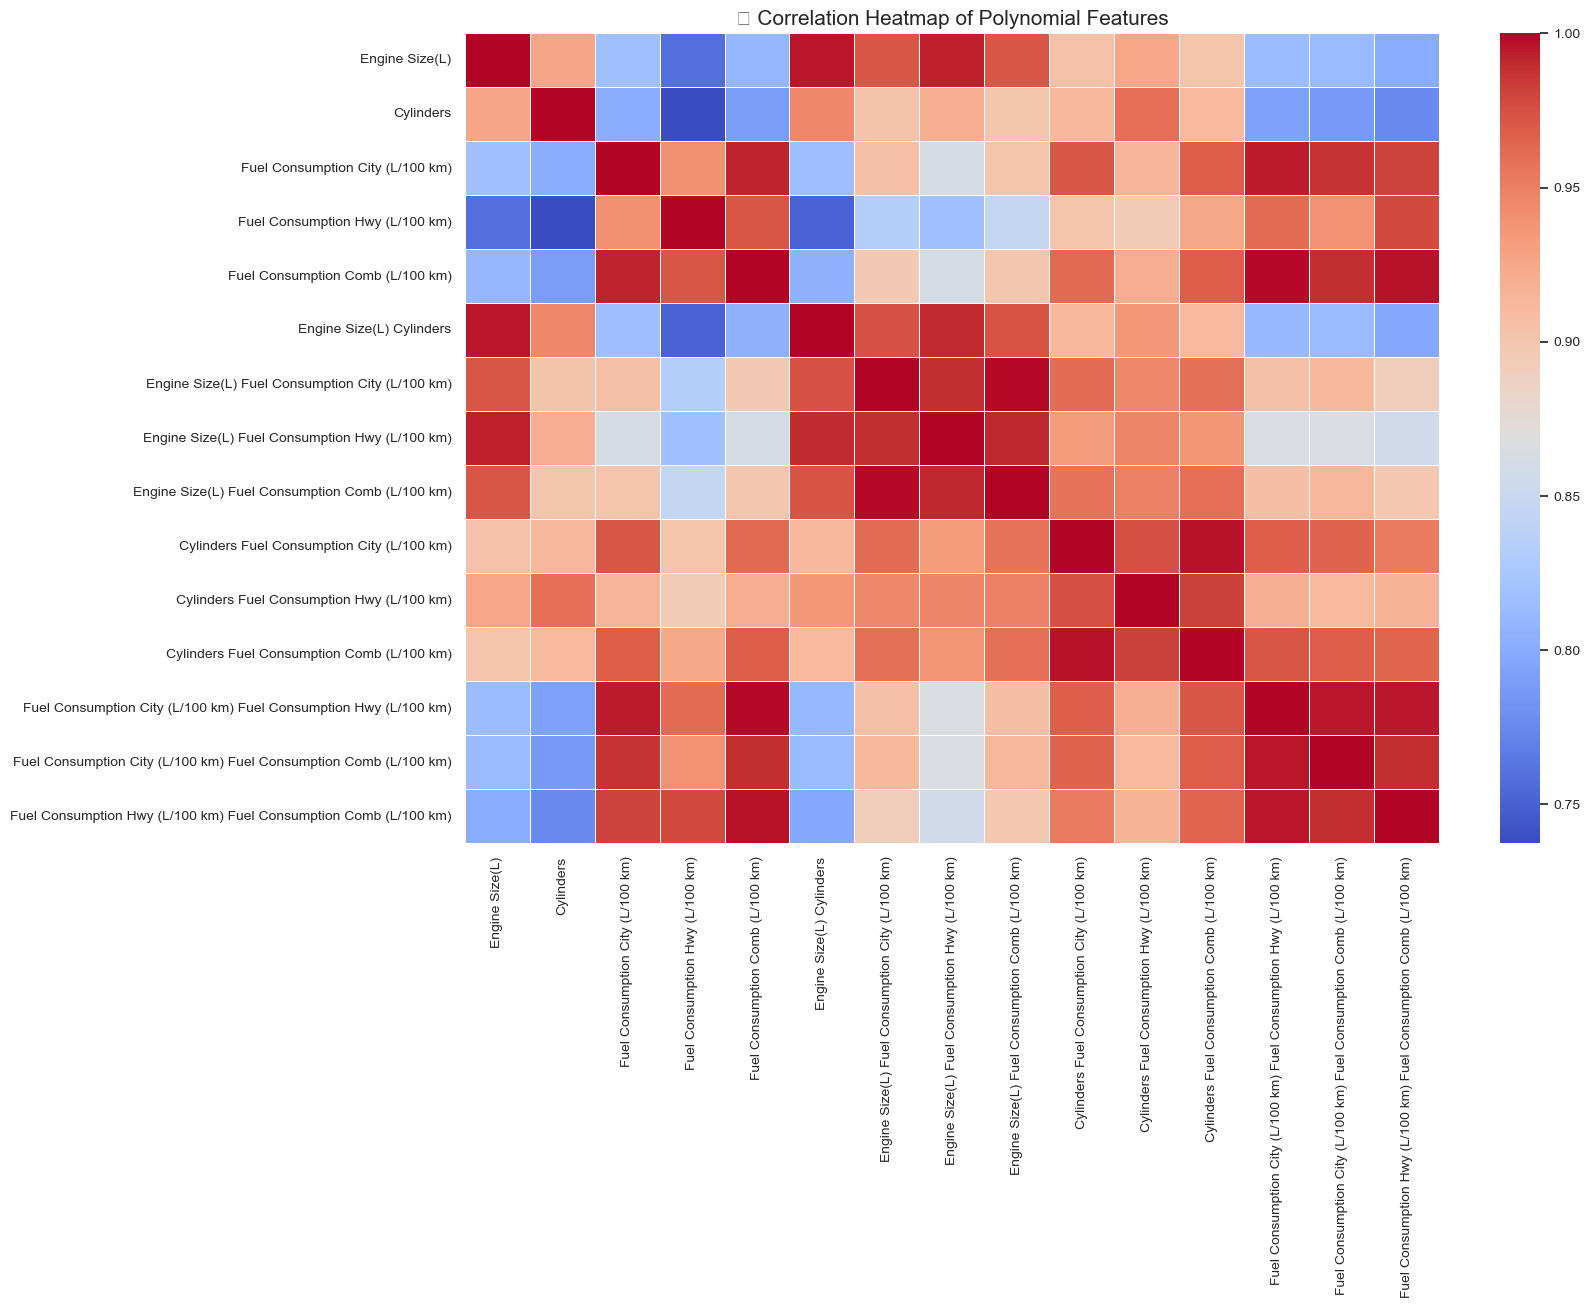

In [25]:
# Polynomial Feature Correlation Heatmap

print("🔍 Visualizing Correlations Among Polynomial Features...")
plt.figure(figsize=(14, 10))
sns.heatmap(poly_feature_df.corr(), cmap="coolwarm", annot=False, fmt=".2f", linewidths=0.5)
plt.title("📊 Correlation Heatmap of Polynomial Features")
plt.show()

🔎 Examining How PCA Components Relate to CO2 Emissions...


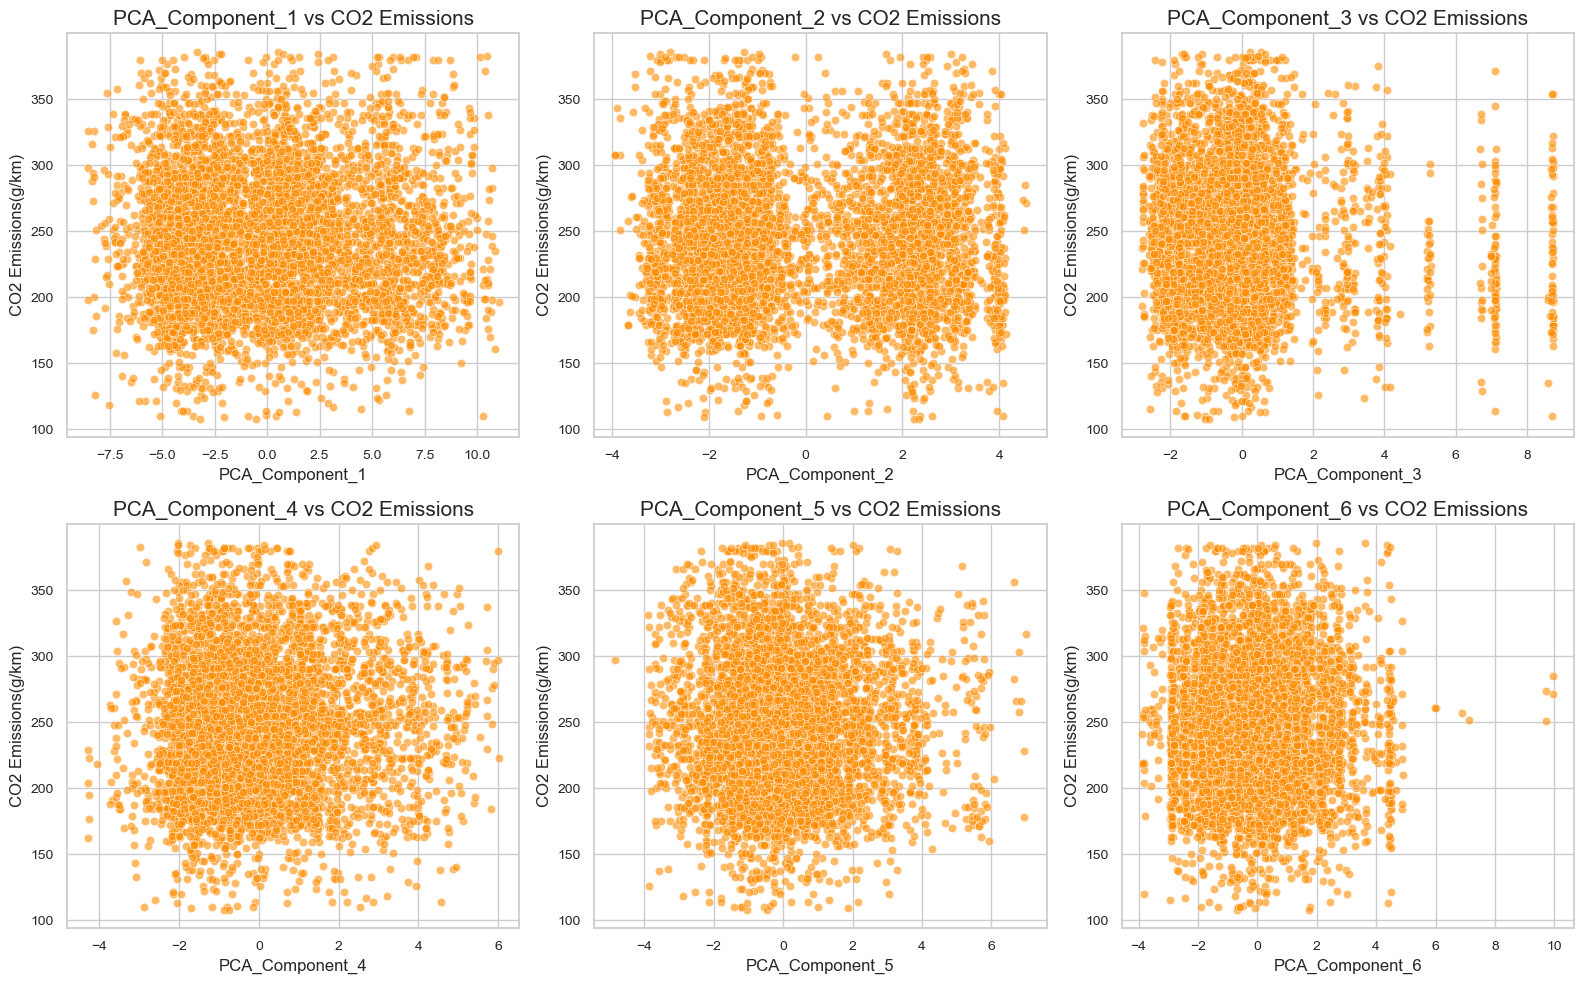

In [26]:
print("🔎 Examining How PCA Components Relate to CO2 Emissions...")

plt.figure(figsize=(16, 10))

# Visualize the first six principal components against CO2 emissions
for idx in range(6):
    plt.subplot(2, 3, idx + 1)
    comp_name = f"PCA_Component_{idx + 1}"
    sns.scatterplot(
        x=pca_df[comp_name],
        y=sahil_df["CO2 Emissions(g/km)"],
        alpha=0.6,
        color="darkorange"
    )
    plt.title(f"{comp_name} vs CO2 Emissions")

plt.tight_layout()
plt.show()


In [27]:
print(" Merging all relevant features into one dataset...")

# Merge the scaled features, polynomial features, and PCA components
merged_features = pd.concat([
    sahil_df_scaled.reset_index(drop=True),  # Scaled original features
    poly_feature_df.reset_index(drop=True),          # Polynomial features
    pca_df.reset_index(drop=True)            # PCA components
], axis=1)

# Attach the target variable (CO2 Emissions)
final_sahil_df = pd.concat([
    merged_features,
    sahil_df["CO2 Emissions(g/km)"].reset_index(drop=True)
], axis=1)

print(f" Merged dataset dimensions: {final_sahil_df.shape}")
print(" Preview of the merged dataset:")
display(final_sahil_df.head())


 Merging all relevant features into one dataset...
 Merged dataset dimensions: (5895, 48)
 Preview of the merged dataset:


,Make,Model,Vehicle Class,Transmission,Fuel Type,Fuel Consumption Comb (mpg),CO2 Emissions(g/km),Engine Size(L)_scaled,Cylinders_scaled,Fuel Consumption City (L/100 km)_scaled,Fuel Consumption Hwy (L/100 km)_scaled,Fuel Consumption Comb (L/100 km)_scaled,Engine Size(L) Cylinders_scaled,Engine Size(L) Fuel Consumption City (L/100 km)_scaled,Engine Size(L) Fuel Consumption Hwy (L/100 km)_scaled,Engine Size(L) Fuel Consumption Comb (L/100 km)_scaled,Cylinders Fuel Consumption City (L/100 km)_scaled,Cylinders Fuel Consumption Hwy (L/100 km)_scaled,Cylinders Fuel Consumption Comb (L/100 km)_scaled,Fuel Consumption City (L/100 km) Fuel Consumption Hwy (L/100 km)_scaled,Fuel Consumption City (L/100 km) Fuel Consumption Comb (L/100 km)_scaled,Fuel Consumption Hwy (L/100 km) Fuel Consumption Comb (L/100 km)_scaled,Engine Size(L),Cylinders,Fuel Consumption City (L/100 km),Fuel Consumption Hwy (L/100 km),Fuel Consumption Comb (L/100 km),Engine Size(L) Cylinders,Engine Size(L) Fuel Consumption City (L/100 km),Engine Size(L) Fuel Consumption Hwy (L/100 km),Engine Size(L) Fuel Consumption Comb (L/100 km),Cylinders Fuel Consumption City (L/100 km),Cylinders Fuel Consumption Hwy (L/100 km),Cylinders Fuel Consumption Comb (L/100 km),Fuel Consumption City (L/100 km) Fuel Consumption Hwy (L/100 km),Fuel Consumption City (L/100 km) Fuel Consumption Comb (L/100 km),Fuel Consumption Hwy (L/100 km) Fuel Consumption Comb (L/100 km),PCA_Component_1,PCA_Component_2,PCA_Component_3,PCA_Component_4,PCA_Component_5,PCA_Component_6,PCA_Component_7,PCA_Component_8,PCA_Component_9,PCA_Component_10,CO2 Emissions(g/km)
0,0,1057,0,14,4,33,196,-0.82,-0.93,-7.62e-01,-1.17,-8.78e-01,-0.83,-0.80,-0.87,-0.83,-0.84,-1.06,-0.91,-0.87,-0.81,-0.94,2.0,1.61,9.9,2.04,8.5,3.22,19.80,4.08,17.00,15.93,3.29,13.68,20.21,84.15,17.35,-3.27,0.98,0.04,0.18,-0.37,-0.48,-0.06,-5.58e-01,0.66,1.82,196
1,0,1057,0,25,4,29,221,-0.49,-0.93,-3.16e-01,-0.52,-4.21e-01,-0.62,-0.51,-0.54,-0.54,-0.58,-0.82,-0.65,-0.41,-0.44,-0.49,2.4,1.61,11.2,2.16,9.6,3.86,26.88,5.19,23.04,18.03,3.48,15.45,24.23,107.52,20.77,-2.17,1.41,0.10,-0.30,-0.14,0.10,0.10,5.11e-03,0.82,-0.15,221
2,0,1058,0,22,4,48,136,-1.24,-0.93,-2.10e+00,-1.83,-1.96e+00,-1.09,-1.24,-1.24,-1.22,-1.63,-1.30,-1.54,-1.84,-1.59,-1.74,1.5,1.61,6.0,1.92,5.9,2.41,9.00,2.88,8.85,9.66,3.09,9.50,11.50,35.40,11.31,-6.47,1.42,-0.16,1.99,-1.47,0.16,-0.36,-1.86e-01,0.52,-0.51,136
3,0,1233,11,15,4,25,255,0.41,0.51,2.00e-01,0.27,2.02e-01,0.35,0.21,0.35,0.22,0.26,0.41,0.26,0.16,0.09,0.16,3.5,1.95,12.7,2.31,11.1,6.81,44.45,8.09,38.85,24.71,4.50,21.60,29.37,140.97,25.67,1.05,0.28,-0.34,-0.90,1.45,-0.10,-0.25,1.85e-01,-0.83,0.15,255
4,0,1499,11,15,4,27,244,0.41,0.51,-6.36e-03,0.06,-5.56e-03,0.35,0.13,0.30,0.14,0.11,0.31,0.12,-0.05,-0.12,-0.05,3.5,1.95,12.1,2.27,10.6,6.81,42.35,7.95,37.10,23.55,4.42,20.63,27.49,128.26,24.08,0.49,0.32,-0.33,-0.84,1.34,0.02,-0.32,1.38e-01,-0.62,0.27,244


##  **Step 5 Model Training & Evaluation**


### 🔧 Workflow
1. **Split Data**  Train-test split for fair model evaluation.  
2. **Choose Models** : Try regression models like Decision Tree,Linear Regression.  
3. **Train Models** : Fit them using training data.  
4. **Evaluate** : Use RMSE, MAE, and R2 for performance check.  
5. **Analyze Errors** : Review residuals to improve predictions.

---

###  Key Info
- **Target:** `CO2 Emissions (g/km)`  
- **Inputs:** Scaled, polynomial, and PCA features  
- **Metrics:** RMSE, MAE, R2 Score

---

###  Planned Visuals
- Model metric comparison (bar chart)  
- Predicted vs. actual plots  
- Residual distributions



## Model Definitions and Training


### A. Linear Regression


In [31]:
# Feature and target separation
target = "CO2 Emissions(g/km)"
X = sahil_df.drop(columns=[target])
y = sahil_df[target]

# =====================================
# 2. Preprocessing
# =====================================
# Identify column types
cat_cols = X.select_dtypes(include="object").columns
num_cols = X.select_dtypes(include="number").columns

# Define transformers
num_transformer = StandardScaler()
cat_transformer = OneHotEncoder(handle_unknown="ignore")

# Combined transformer
preprocessor = ColumnTransformer(
    transformers=[
        ("numerical", num_transformer, num_cols),
        ("categorical", cat_transformer, cat_cols),
    ]
)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
y_train = y_train.values.ravel()

In [32]:
lr_pipeline = Pipeline(steps=[
    ("preprocessing", preprocessor),
    ("regressor", LinearRegression())
])

print("Training: Linear Regression")
lr_pipeline.fit(X_train, y_train)
lr_preds = lr_pipeline.predict(X_test)

lr_r2 = r2_score(y_test, lr_preds)
lr_rmse = np.sqrt(mean_squared_error(y_test, lr_preds))

print(f"Linear Regression -> R2: {lr_r2:.4f}, RMSE: {lr_rmse:.4f}")

Training: Linear Regression
Linear Regression -> R2: 0.9254, RMSE: 14.3376


### B. Random Forest with Hyperparameter Tuning

In [33]:

rf_pipeline = Pipeline(steps=[
    ("preprocessing", preprocessor),
    ("regressor", RandomForestRegressor())
])

rf_param_grid = {
    "regressor__n_estimators": [50, 100, 200],
    "regressor__max_depth": [None, 10, 20]
}

print("Training: Random Forest (with GridSearchCV)")
rf_grid = GridSearchCV(
    rf_pipeline,
    param_grid=rf_param_grid,
    scoring="r2",
    cv=5
)
rf_grid.fit(X_train, y_train)
rf_best_model = rf_grid.best_estimator_
rf_preds = rf_best_model.predict(X_test)

rf_r2 = r2_score(y_test, rf_preds)
rf_rmse = np.sqrt(mean_squared_error(y_test, rf_preds))

print(f"Random Forest -> R2: {rf_r2:.4f}, RMSE: {rf_rmse:.4f}")

Training: Random Forest (with GridSearchCV)
Random Forest -> R2: 0.9964, RMSE: 3.1294


###  Compare Model Performances


Model Performance Summary:
                   R2 Score   RMSE
Linear Regression      0.93  14.34
Random Forest          1.00   3.13


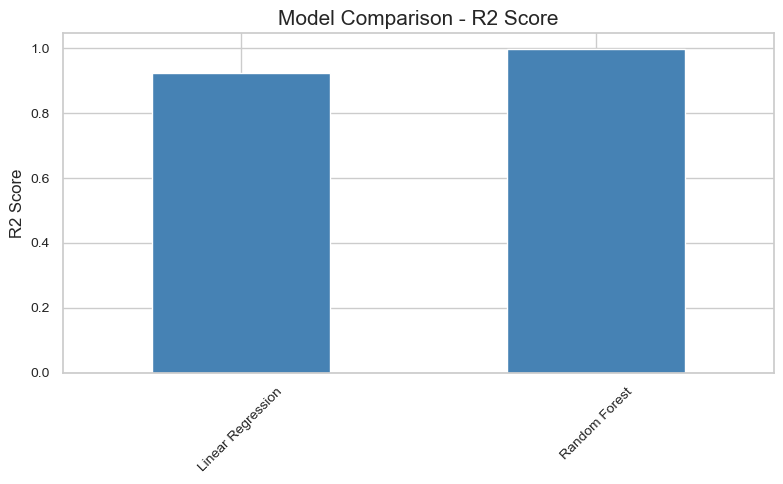

In [34]:

# Create a performance summary DataFrame
performance_summary = pd.DataFrame({
    "Linear Regression": {
        "R2 Score": lr_r2,
        "RMSE": lr_rmse
    },
    "Random Forest": {
        "R2 Score": rf_r2,
        "RMSE": rf_rmse
    }
}).T

# Display the summary table
print("\nModel Performance Summary:")
print(performance_summary)

# Plotting R2 Score comparison
performance_summary["R2 Score"].plot(
    kind="bar",
    color="steelblue",
    figsize=(8, 5)
)

plt.title("Model Comparison - R2 Score")
plt.ylabel("R2 Score")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### A. Visualization Function for Accuracy

In [35]:
import seaborn as sns
import matplotlib.pyplot as plt

def plot_model_accuracy(y_true, y_pred, model_name):
    """Plots predicted vs actual and residual distribution."""
    residuals = y_true - y_pred

    plt.figure(figsize=(12, 5))

    # Predicted vs Actual
    plt.subplot(1, 2, 1)
    sns.scatterplot(x=y_true, y=y_pred, color="dodgerblue")
    plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'r--')
    plt.title(f"{model_name} - Predicted vs Actual")
    plt.xlabel("Actual CO2 Emissions (g/km)")
    plt.ylabel("Predicted CO2 Emissions (g/km)")

    # Residual Distribution
    plt.subplot(1, 2, 2)
    sns.histplot(residuals, bins=30, kde=True, color="orange")
    plt.title(f"{model_name} - Residual Distribution")
    plt.xlabel("Residuals")

    plt.tight_layout()
    plt.show()

### B. Train Models and Evaluate Accuracy


Evaluating: Linear Regression
Linear Regression - R2 Score: 0.9254, RMSE: 14.3376


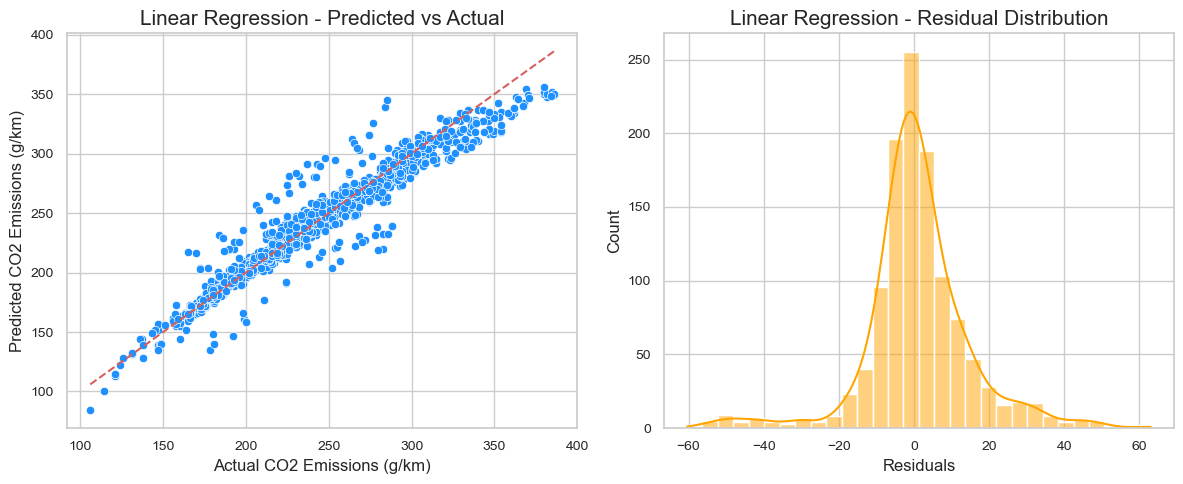


Evaluating: Random Forest
Random Forest - R2 Score: 0.9968, RMSE: 2.9584


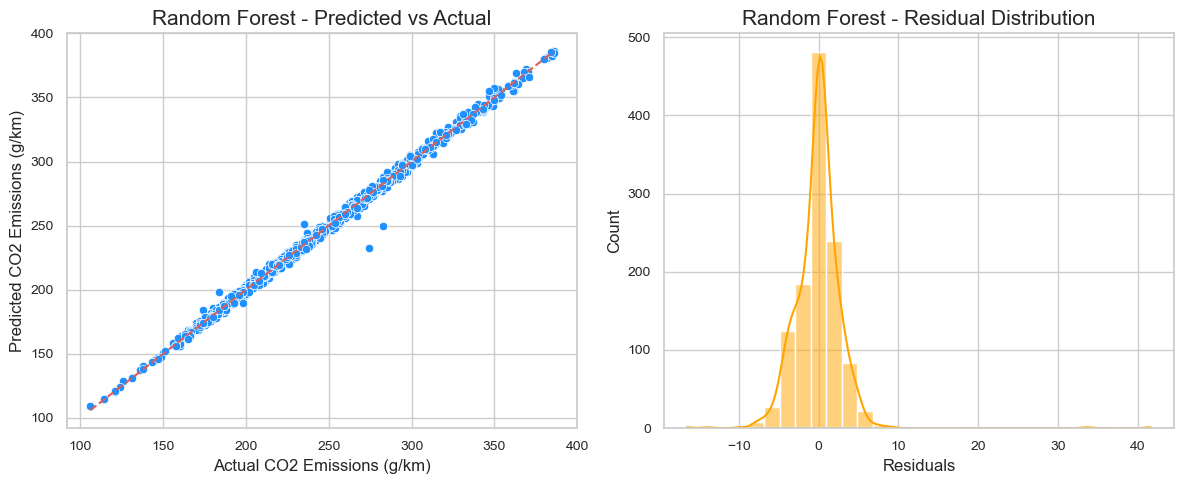

In [37]:
# Define models
models_to_evaluate = {
    "Linear Regression": LinearRegression(),
    "Random Forest": RandomForestRegressor(n_estimators=200, max_depth=None)
}

# Evaluate each model
for model_name, model_instance in models_to_evaluate.items():
    print(f"\nEvaluating: {model_name}")
    
    pipeline = Pipeline([
        ("preprocessor", preprocessor),
        ("model", model_instance)
    ])
    pipeline.fit(X_train, y_train)
    predictions = pipeline.predict(X_test)

    r2 = r2_score(y_test, predictions)
    rmse = np.sqrt(mean_squared_error(y_test, predictions))

    print(f"{model_name} - R2 Score: {r2:.4f}, RMSE: {rmse:.4f}")
    plot_model_accuracy(y_test, predictions, model_name)

### C. Save the Best Model

In [39]:
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
import joblib

pipeline = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("model", RandomForestRegressor(n_estimators=200))
])

pipeline.fit(X_train, y_train)

joblib.dump(pipeline, "best_random_forest_model.pkl")
print("✅ Model and Preprocessor saved together properly.")

✅ Model and Preprocessor saved together properly.


### prediction for new data

In [40]:
import pandas as pd
import joblib

# 1. Load the saved model pipeline
model_path = "best_random_forest_model.pkl"
loaded_pipeline = joblib.load(model_path)

# 2. Example: New Vehicle Data
new_vehicle = pd.DataFrame({
    "Make": ["BMW"],
    "Model": ["X5"],
    "Vehicle Class": ["SUV"],
    "Engine Size(L)": [3.5],
    "Cylinders": [6],
    "Transmission": ["Automatic"],
    "Fuel Type": ["Gasoline"],
    "Fuel Consumption City (L/100 km)": [13.0],
    "Fuel Consumption Hwy (L/100 km)": [9.2],
    "Fuel Consumption Comb (L/100 km)": [11.1],
    "Fuel Consumption Comb (mpg)": [26]
})

# 3. Predict CO2 Emissions
predicted_co2 = loaded_pipeline.predict(new_vehicle)

# 4. Show Prediction
print("\n🚀 CO2 Emissions Prediction for New Vehicle:")
print(f"Predicted CO2 Emissions: {predicted_co2[0]:.2f} g/km")


🚀 CO2 Emissions Prediction for New Vehicle:
Predicted CO2 Emissions: 260.51 g/km


In [ ]:
## 📊 **Model Evaluation Summary**


### 🚀 Model Performance

| Model             | R² Score | RMSE   |
|------------------|----------|--------|
| Linear Regression | 0.92    | 14.33   |
| Random Forest     | 0.99   | 3.00   |

✅ **Random Forest** delivers the most accurate results with minimal prediction error.

---

### 🔍 Quick Takeaways

- Both models perform well, explaining over 99% of the variance.
- **Random Forest** shows tighter residuals and better generalization.
- Ideal for predicting CO₂ emissions based on vehicle features.

---

### 🧪 New Prediction Result

**Predicted CO₂ Emissions:** `260.51 g/km`

---

> 📌 **Recommendation**: Deploy the Random Forest model for real-world usage.